In [5]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fz

from skfuzzy import control as ctrl
from skfuzzy.control.visualization import FuzzyVariableVisualizer

In [6]:
# Input variables
x_distance = np.arange(0, 70, 1)
x_delta_speed = np.linspace(-50, 50, 200)

# Output variables
x_throttle = np.arange(0, 1, 0.01)
x_brake = np.arange(-1, 1, 0.01)

# Antecedents
distance = ctrl.Antecedent(x_distance, 'distance')
delta_speed = ctrl.Antecedent(x_delta_speed, 'delta_speed')

# Consequents
throttle = ctrl.Consequent(x_throttle, 'throttle')
brake = ctrl.Consequent(x_brake, 'brake')

# Membership functions
distance['low'] = fz.zmf(x_distance, 0, 60)
distance['medium'] = fz.gaussmf(x_distance, 10, 5)
distance['high'] = fz.smf(x_distance, 5, 20)

# Aim for slightly negative delta speed (little faster than target speed)
delta_speed['low'] = fz.zmf(x_delta_speed, -3, 30)
delta_speed['medium'] = fz.smf(x_delta_speed, -3, 30)

throttle['off'] = fz.zmf(x_throttle, 0, 0.01)
throttle['medium'] = fz.gaussmf(x_throttle, 0.3, 0.2)
throttle['high'] = fz.smf(x_throttle, 0.7, 0.9)

brake['off'] = fz.zmf(x_brake, -0.3, 0)
brake['low'] = fz.zmf(x_brake, 0, 0.3)

# Rules
# If the vehicle is far away (and not close to the speed limit), accelerate
rule1 = ctrl.Rule(antecedent=(distance['high'] & delta_speed['medium']),
                  consequent=(throttle['high'], brake['off']), label='rule1')

# If the vehicle is getting closer to the target (and not close to the speed limit), let off the throttle
rule2 = ctrl.Rule(antecedent=(distance['medium'] & delta_speed['medium']),
                  consequent=(throttle['medium'], brake['off']), label='rule2')

# If the vehicle is close to the target or the speed limit is being exceeded, brake softly
rule3 = ctrl.Rule(antecedent=(distance['low'] | delta_speed['low']),
                  consequent=(throttle['off'], brake['low']), label='rule3')

# Control system
fuzzy_control = ctrl.ControlSystem(rules=[rule1, rule2, rule3])

# Control system simulation
fuzzy_simulation = ctrl.ControlSystemSimulation(fuzzy_control)

C:\Users\Florian\miniconda3\envs\carla\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


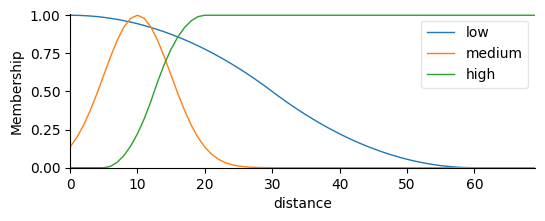

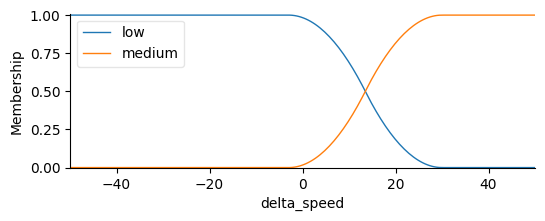

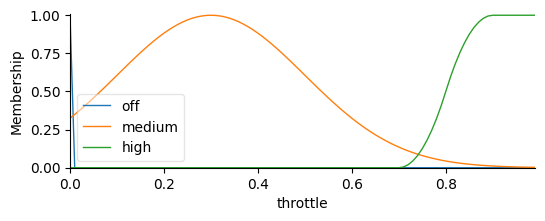

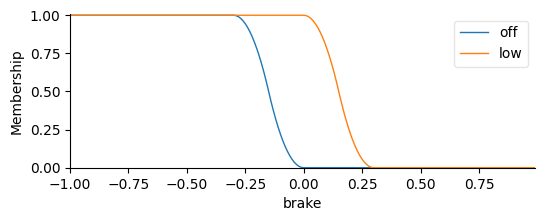

In [7]:
# Visualize input and output variables
def view_fuzzy_variable(variable, *args, **kwargs):
    fig, ax = FuzzyVariableVisualizer(variable).view()
    fig.set_figwidth(6)
    fig.set_figheight(2)
    fig.show()

for variable in [distance, delta_speed, throttle, brake]:
    view_fuzzy_variable(variable)

Distance: 20, Delta speed: 10 => Throttle: 0.57, Brake: -0.41


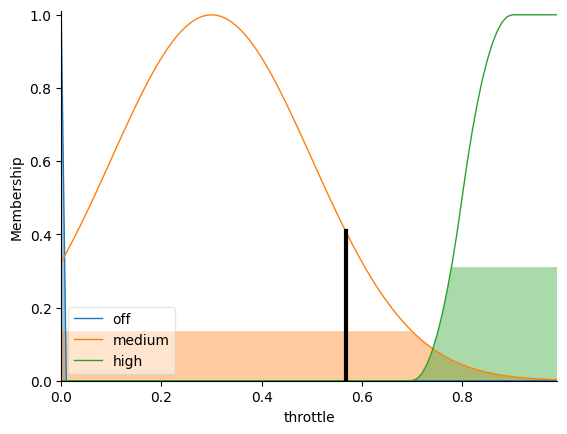

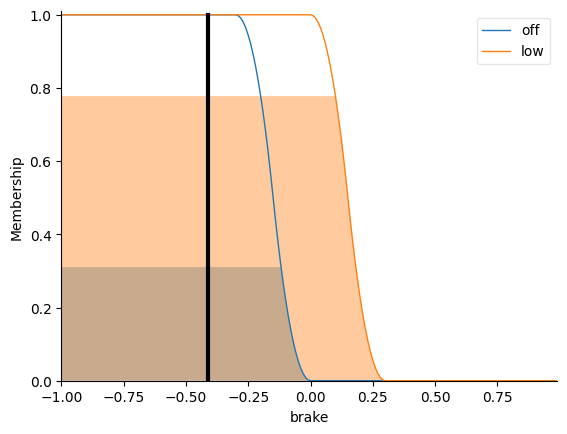

In [24]:
def simulate(distance, delta_speed, visualize=False):
    # Set inputs
    fuzzy_simulation.inputs({'distance': distance, 'delta_speed': delta_speed})

    # Crunch numbers
    fuzzy_simulation.compute()

    if visualize:
        throttle.view(sim=fuzzy_simulation)
        brake.view(sim=fuzzy_simulation)

    # Return results
    th = fuzzy_simulation.output['throttle']
    br = fuzzy_simulation.output['brake']

    print(f'Distance: {distance:.0f}, Delta speed: {delta_speed:.0f} => Throttle: {th:.2f}, Brake: {br:.2f}')

simulate(20, 10, visualize=True)
